# Milestone 2 - Hypothesis Simulation 

## Author - Connor Higgins


## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap and Bayesian methods
3. Compute confidence intervals for the above summary statistics by classical, bootstrap and  Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


#### Preparing DataFrame

In [1]:
# Import libraries
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import statsmodels.stats.api as sms
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.set()

C:\python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [3]:
df = pd.read_csv(fileName)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
# Cleaning numeric data
df = df.replace({'?' : np.nan}) # replacing ? with nan

for i in df.columns: # converting all numeric-like columns into numeric
    try:
        df[i] = pd.to_numeric(df[i]) 
    except ValueError:
        pass

numcols = df.describe().columns # obtaining all numeric columns

for i in numcols: # filling missing values with mean of column
    df[i] = df[i].fillna((df[i].mean())) 
    
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


### Task 1. Identify a likely distribution for price and several other features.

#### 1.A Creating necessary functions

In [5]:
def QQplot(Series1, Series1Name, Series2, Series2Name, DistSeries, DistName):

    """ Creates Quartile-Quartile plots of standardized 
        Series1 and Series2 plotted against DistSeries"""
    
    Series1 = StandardScaler().fit_transform(Series1.values.reshape(-1, 1)) # standardizing
    Series2 = StandardScaler().fit_transform(Series2.values.reshape(-1, 1)) # standardizing
    
    plt.figure(figsize=(16, 6)).gca()
    ax1 = plt.subplot(121)
    plt.scatter(x = sorted(Series1), y = sorted(DistSeries), alpha = 0.5) # provides density visual
    plt.scatter(x = np.arange(np.min(Series1), np.max(Series1), 0.1),
                y = np.arange(np.min(Series1), np.max(Series1), 0.1),
                color = 'r', marker='.')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Observed Values')
    plt.title(f'QQ plot of {DistName} v. {Series1Name}')
    ax2 = plt.subplot(122)
    plt.scatter(x = sorted(Series2), y = sorted(DistSeries), alpha = 0.5)
    plt.scatter(x = np.arange(np.min(Series2), np.max(Series2), 0.1),
                y = np.arange(np.min(Series2), np.max(Series2), 0.1),
                color = 'r', marker='.')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Observed Values')
    plt.title(f'QQ plot of {DistName} v. {Series2Name}')
    plt.show()

def KS_Stat(Series0, SeriesName, dist='norm'):
    
    """Provides the KS_Stat and P-value for Series0 v. dist distribution"""
    
    ks_stat, pval = ss.kstest(Series0, dist)
    print(f'=======KS-Statistics for {SeriesName:{10}} v. {dist:{4}} distribution =======')
    print(f'.......KS-Stat: {ks_stat:{0}.{6}}.................................')
    print(f'.......P-value: {pval:{0}.{6}}.................................')
    return

#### 1.B Identifying likely distribution for Price

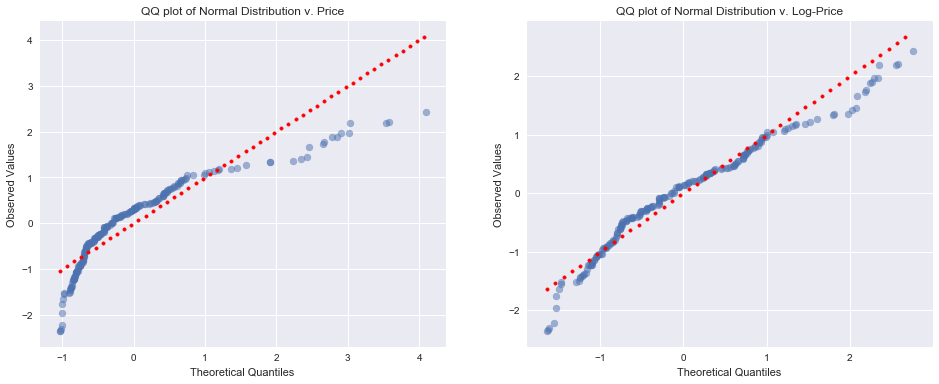

=======KS-Statistics for price      v. norm distribution =======
.......KS-Stat: 0.151383.................................
.......P-value: 0.000144471.................................
=======KS-Statistics for log-price  v. norm distribution =======
.......KS-Stat: 0.0920981.................................
.......P-value: 0.0579123.................................


In [6]:
df['log-price'] = df['price'].apply(lambda x : np.log(x)) # creating log of price
QQplot(df['price'], 'Price', df['log-price'], 'Log-Price', # does log-price or price follow norm dist? 
       np.random.normal(size=len(df)), 'Normal Distribution')

df['price-standardized'] = StandardScaler().fit_transform(df['price'].values.reshape(-1, 1))
KS_Stat(df['price-standardized'], 'price') # obtaining KS_Stat on standardized price series

df['log-price-standardized'] = StandardScaler().fit_transform(df['log-price'].values.reshape(-1, 1))
KS_Stat(df['log-price-standardized'], 'log-price') # obtaining KS_Stat on standardized log-price series

Log-Price likely is a normal distribution, whereas the same can't be said for Price.

#### 1.C Identifying likely distribution for Length

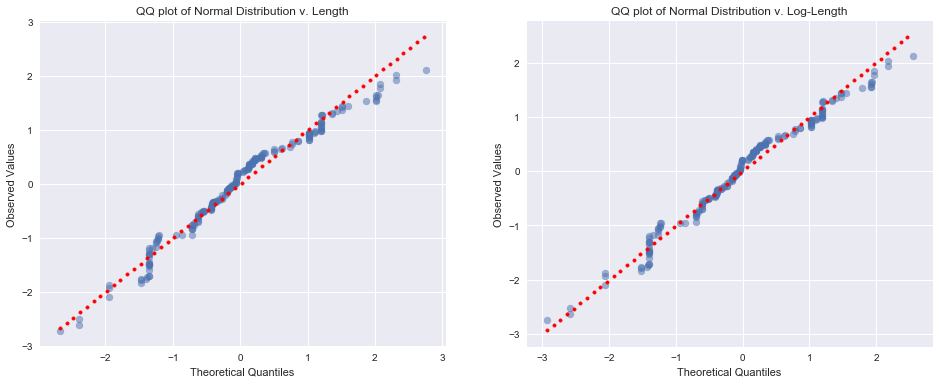

=======KS-Statistics for Length     v. norm distribution =======
.......KS-Stat: 0.0875915.................................
.......P-value: 0.0810291.................................
=======KS-Statistics for Log-Length v. norm distribution =======
.......KS-Stat: 0.0754895.................................
.......P-value: 0.183761.................................


In [7]:
df['log-length'] = df['length'].apply(lambda x : np.log(x))

QQplot(df['length'], 'Length',
       df['log-length'], 'Log-Length',
       np.random.normal(size=len(df)), 'Normal Distribution')

df['length-standardized'] = StandardScaler().fit_transform(df['length'].values.reshape(-1, 1))
KS_Stat(df['length-standardized'], 'Length')
df['log-length-standardized'] = StandardScaler().fit_transform(df['log-length'].values.reshape(-1, 1))
KS_Stat(df['log-length-standardized'], 'Log-Length')

Both Length and Log-Length likely follow normal distributions; however, Log-Length does so more closely than Length.

#### 1.D Identifying likely distribution for Height

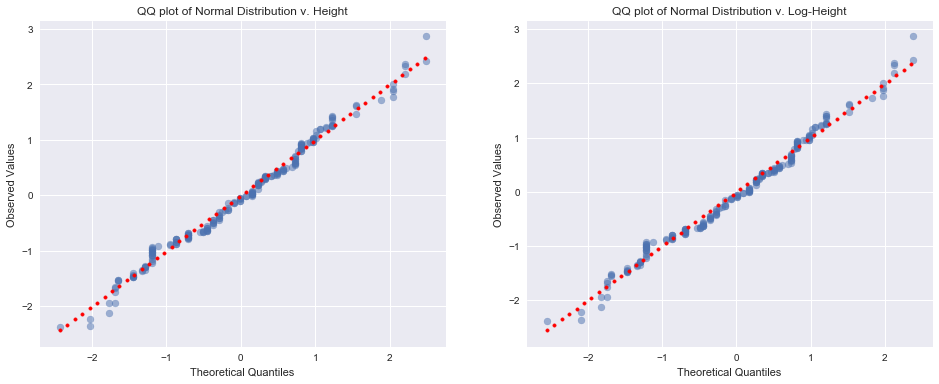

=======KS-Statistics for Height     v. norm distribution =======
.......KS-Stat: 0.0751593.................................
.......P-value: 0.187595.................................
=======KS-Statistics for Log-Height v. norm distribution =======
.......KS-Stat: 0.0820236.................................
.......P-value: 0.11989.................................


In [8]:
df['log-height'] = df['height'].apply(lambda x : np.log(x))

QQplot(df['height'], 'Height',
       df['log-height'], 'Log-Height',
       np.random.normal(size=len(df)), 'Normal Distribution')

df['height-standardized'] = StandardScaler().fit_transform(df['height'].values.reshape(-1, 1))
KS_Stat(df['height-standardized'], 'Height')
df['log-height-standardized'] = StandardScaler().fit_transform(df['log-height'].values.reshape(-1, 1))
KS_Stat(df['log-height-standardized'], 'Log-Height')

Both Height and Log-Height likely follow normal distributions; however, Height does so more closely than Log-Height.

#### 1.E Identifying likely distribution for Highway-mpg

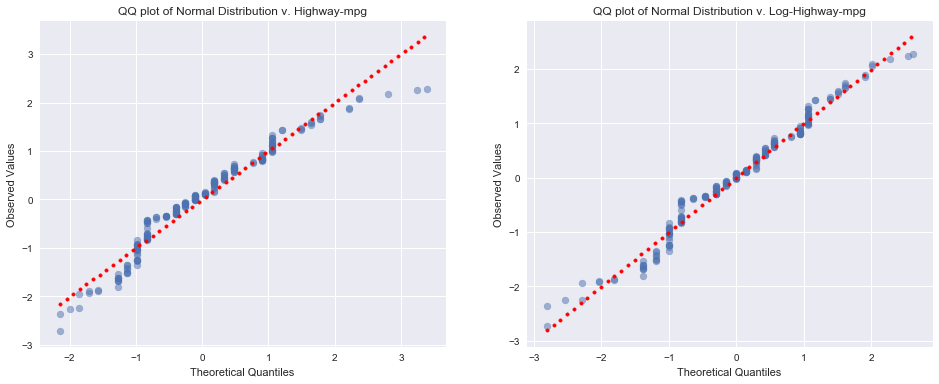

=======KS-Statistics for Highway-mpg v. norm distribution =======
.......KS-Stat: 0.0914416.................................
.......P-value: 0.0608804.................................
=======KS-Statistics for Log-Highway-mpg v. norm distribution =======
.......KS-Stat: 0.0849859.................................
.......P-value: 0.0976446.................................


In [9]:
df['highway-mpg'] = df['highway-mpg'].astype(float)

df['log-highway-mpg'] = df['highway-mpg'].apply(lambda x : np.log(x))

QQplot(df['highway-mpg'], 'Highway-mpg',
       df['log-highway-mpg'], 'Log-Highway-mpg',
       np.random.normal(size=len(df)), 'Normal Distribution')

df['highway-mpg-standardized'] = StandardScaler().fit_transform(df['highway-mpg'].values.reshape(-1, 1))
KS_Stat(df['highway-mpg-standardized'], 'Highway-mpg')
df['log-highway-mpg-standardized'] = StandardScaler().fit_transform(df['log-highway-mpg'].values.reshape(-1, 1))
KS_Stat(df['log-highway-mpg-standardized'], 'Log-Highway-mpg')

Both Highway-mpg and Log-Highway-mpg likely follow normal distributions, slightly moreso with the distribution of Log-Highway-mpg.

### Task 2. Compute basic summary statistics by both classical, bootstrap and Bayesian methods

#### 2.A Defining function

In [10]:
def ClassicBootBayesSummaryStats(Series0, Series0name, n_replicas):
    
    """ Returns a summary statistics dataframe for the population of Series0 as well as for
        Series0 samples obtained using classical, bootstrap, and bayesian methods. Addiitonally,
        it returns a plot of the Bayesian distributions for Series0 created from n n_replicas. """
    
    # Population Summary Stats
    Population = pd.DataFrame(data={'Population' : Series0.describe()}) # full population
    
    # Classical Summary Stats
    Classical = pd.DataFrame(data={'Classical' : Series0.sample(n=round(0.25*n_replicas)).describe()}) # sampling 1/4 population
    
    # Bootstrap Summary Stats
    Bootstrap = pd.Series([Series0.sample(frac=1, replace=True).mean() for i in range(n_replicas)]) # bootstrap
    Bootstrap = pd.DataFrame(data={'Bootstrap' : Bootstrap.describe()})
    
    # Bayesian Summary Stats
    p = np.linspace(min(Series0), max(Series0), num=n_replicas) # obtaining uniform distribution the size and range of Series0
    pp = ss.norm.pdf(p, loc=Series0.mean(), scale=np.std(Series0)) # creating prior pdf using Series0 properties
    pp = pp / pp.sum() # normalizing
    
    variance = np.std(Series0)**2 # variance of Series0
    x_mean = np.asarray(Series0).mean() # mean of Series0
    n = len(Series0) # length of Series0
    l = np.exp(-n * (x_mean - p)**2 / (2 * variance)) # obtaining Normal likelihood using Series0 properties
    like_series = l / l.sum() # normalizing
    
    post_series = pp * like_series # obtaining posterior from product of prior and likelihood
    post_series = post_series / sum(post_series) # normalizing
    
    Mu = np.random.choice(p, size=n_replicas, replace=True, p=post_series) #  n samples of p distribution using posterior probabilities
    Bayesian = pd.Series(ss.norm.rvs(loc=Mu, scale=np.std(Series0), size=len(Series0))) # Simulating Series0
    Bayesian = pd.DataFrame(data={'Bayesian' : Bayesian.describe()})
    
    # Plotting Bayesian Distributions
    plt.plot(p, pp, label='prior')
    plt.plot(p, like_series, label='likelihood', alpha=.3, linewidth=10)
    plt.plot(p, post_series, label='posterior')
    plt.xlabel(f'{Series0name}')
    plt.ylabel('Frequency')
    plt.title(f'Prior, Likelihood, & Posterior Distributions\n for {Series0name}')
    plt.legend()
    plt.show()

    return pd.concat([Population, Classical, Bootstrap, Bayesian], axis=1) # Summary Stat DataFrame

#### 2.B Summary Statistics for Log-Price

Log-Price was used in lieu of Price, as it more closely follows a normal distribution.

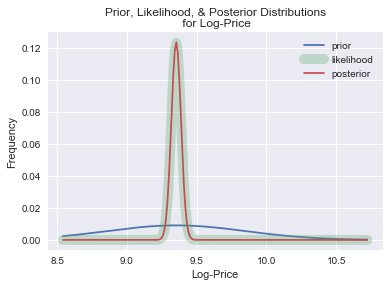

,Population,Classical,Bootstrap,Bayesian
count,205.000000,51.000000,205.000000,205.000000
mean,9.352815,9.453162,9.352714,9.352368
std,0.497673,0.565360,0.035302,0.517117
min,8.540519,8.546946,9.244479,7.858918
25%,8.960339,8.999827,9.329601,9.042304
50%,9.268137,9.428672,9.353846,9.320706
75%,9.711116,9.774490,9.376486,9.706763
max,10.723267,10.723267,9.453255,10.638105


In [11]:
ClassicBootBayesSummaryStats(df['log-price'], 'Log-Price', len(df['log-price']))

As expected, the Bootstrap distribution, consisting of sampled means (and therefore lower variance), has a far lower standard deviation than the other distributions. The Bayesian distribution, on the other hand, has the highest standard deviation in part due to its underlying prior distribution.

#### 2.C Summary Statistics for Log-Length

Log-Length was used in lieu of Length, as it more closely follows a normal distribution.

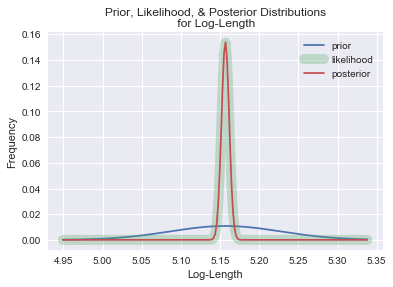

,Population,Classical,Bootstrap,Bayesian
count,205.000000,51.000000,205.000000,205.000000
mean,5.156839,5.151895,5.156723,5.156790
std,0.070921,0.078401,0.004914,0.066669
min,4.949469,4.973971,5.143954,4.981041
25%,5.113793,5.110778,5.153826,5.115046
50%,5.154447,5.149817,5.156984,5.159506
75%,5.210032,5.228967,5.159183,5.201710
max,5.338019,5.296315,5.170238,5.344262


In [12]:
ClassicBootBayesSummaryStats(df['log-length'], 'Log-Length', len(df['log-length']))

#### 2.D Summary Statistics for Height

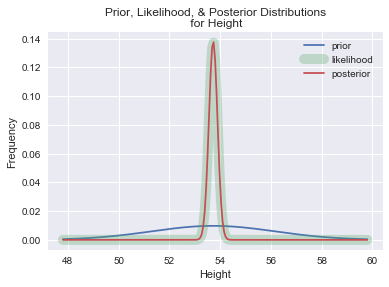

,Population,Classical,Bootstrap,Bayesian
count,205.000000,51.000000,205.000000,205.000000
mean,53.724878,54.019608,53.719964,53.917837
std,2.443522,2.537953,0.184880,2.443822
min,47.800000,47.800000,53.336098,47.425690
25%,52.000000,52.000000,53.582927,52.170062
50%,54.100000,54.300000,53.710244,53.892378
75%,55.500000,55.700000,53.836098,55.612772
max,59.800000,59.800000,54.284390,61.095521


In [13]:
ClassicBootBayesSummaryStats(df['height'], 'Height', len(df['height']))

#### 2.E Summary Statistics for Log-Highway-mpg

Log-Highway-mpg was used in lieu of Highway-mpg, as it more closely follows a normal distribution.

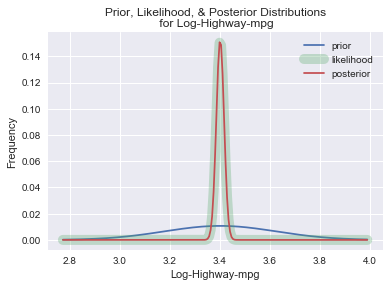

,Population,Classical,Bootstrap,Bayesian
count,205.000000,51.000000,205.000000,205.000000
mean,3.401121,3.367119,3.402191,3.398697
std,0.224316,0.238828,0.015394,0.218920
min,2.772589,2.772589,3.362757,2.828880
25%,3.218876,3.198465,3.391784,3.242188
50%,3.401197,3.401197,3.400958,3.391196
75%,3.526361,3.526361,3.412824,3.546575
max,3.988984,3.850148,3.448011,3.970258


In [14]:
ClassicBootBayesSummaryStats(df['log-highway-mpg'], 'Log-Highway-mpg', len(df['log-highway-mpg']))

### Task 3. Compute confidence intervals for the above summary statistics by classical, bootstrap and Bayesian methods

#### 3.A Defining Function

In [15]:
def ClassicBootBayesConfInt(Series0, Series0name, alpha=0.95):
    
    """ Computes a DataFrame of High and Low CIs for the Series0 population as well as
    Series0 samples obtained through Classical, Bootstrap, and Bayesian methods. """
    
    # Population
    pop_mean = Series0.mean()
    pop_std = np.std(Series0)
    half_width = ss.norm.ppf((1 + alpha)/2, loc=pop_mean, scale=pop_std) - pop_mean
    ci_low = pop_mean - half_width
    ci_high = pop_mean + half_width
    PopCI = (ci_low, ci_high)
    
    # Classical - sampling 1/4 of population at random
    Classical = Series0.sample(n=round(0.25*len(Series0)))
    
    sample_mean = Classical.mean()
    sample_std = np.std(Classical)
    half_width = ss.norm.ppf((1 + alpha)/2, loc=sample_mean, scale=sample_std) - sample_mean
    ci_low = sample_mean - half_width
    ci_high = sample_mean + half_width
    ClassCI = (ci_low, ci_high) # saving as tuple
    
    # Bootstrap - sampling population means with replacement
    Bootstrap = pd.Series([Series0.sample(frac=1, replace=True).mean() for i in range(len(Series0))])

    sample_mean = Bootstrap.mean()
    sample_std = np.std(Bootstrap)
    half_width = ss.norm.ppf((1 + alpha)/2, loc=sample_mean, scale=sample_std) - sample_mean
    ci_low = sample_mean - half_width
    ci_high = sample_mean + half_width
    BootCI = (ci_low, ci_high)
    
    # Bayesian - sampling using a created posterior distribution
    p = np.linspace(min(Series0), max(Series0), num=len(Series0))
    pp = ss.norm.pdf(p, loc=Series0.mean(), scale=np.std(Series0)) # creating prior pdf using Series0 properties
    pp = pp / pp.sum() # normalizing
    
    variance = np.std(Series0)**2
    x_mean = np.asarray(Series0).mean()
    n = len(Series0)
    l = np.exp(-n * (x_mean - p)**2 / (2 * variance)) # obtaining Normal likelihood using Series0 properties
    like_series = l / l.sum() # normalizing
    
    post_series = pp * like_series # obtaining posterior from product of prior and likelihood
    post_series = post_series / sum(post_series) # normalizing
    
    Mu = np.random.choice(p, size=len(Series0), replace=True, p=post_series) #  sampling using posterior probabilities
    Bayesian = pd.Series(ss.norm.rvs(loc=Mu, scale=np.std(Series0), size=len(Series0))) # Simulating Series0
    BayesCI = np.percentile(Bayesian,
                            [100*(1-alpha)/2, 100 - 100*(1-alpha)/2]) # obtaining credibility interval percentiles
    
    # Plotting Distributions with CIs
    
    plt.figure(figsize=(10, 8)).gca()
    
    ax1 = plt.subplot(221)
    sns.distplot(Series0, ax=ax1)
    plt.axvline(np.mean(Series0), color='b', ls=':') # plotting vertical line denoting mean
    plt.axvline(PopCI[0], 0, 1, color='r', label='CI-Low') # plotting vertical line representing low CI
    plt.axvline(PopCI[1], 0, 1, color='g', label='CI-High') # plotting vertical line representing high CI
    plt.title(f'Distribution Plot of {Series0name} Population')
    plt.ylabel('Frequency')
    plt.xlabel('')
    
    ax2 = plt.subplot(222)
    sns.distplot(Classical, ax=ax2)
    plt.axvline(np.mean(Classical), color='b', ls=':', label="Mean")
    plt.axvline(ClassCI[0], 0, 1, color='r', label='CI_Low')
    plt.axvline(ClassCI[1], 0, 1, color='g', label='CI_High')
    plt.title(f'{Series0name} Sample (Classical)')
    plt.xlabel('')
    plt.legend()
    
    ax3 = plt.subplot(223)
    d = sns.distplot(Bootstrap, ax=ax3)
    plt.axvline(np.mean(Bootstrap), color='b', ls=':')
    plt.axvline(BootCI[0], 0, 1, color='r', label='CI_Low')
    plt.axvline(BootCI[1], 0, 1, color='g', label='CI_High')
    plt.title(f'{Series0name} Sample (Bootstrap)')
    plt.ylabel('Frequency')
    plt.xlabel(f'{Series0name}')
    plt.yticks(d.get_yticks(), d.get_yticks() * 0.1) # Matching other subplot y-tick labels
    
    ax4 = plt.subplot(224)
    sns.distplot(Bayesian, ax=ax4)
    plt.axvline(np.mean(Bayesian), color='b', ls=':')
    plt.axvline(BayesCI[0], 0, 1, color='r', label='CI_Low')
    plt.axvline(BayesCI[1], 0, 1, color='g', label='CI_High')
    plt.title(f'{Series0name} Sample (Bayesian)')
    plt.xlabel(f'{Series0name}')
    
    plt.show()
    
    return pd.DataFrame(data={'Population' : PopCI, 'Classical' : ClassCI, 'Bootstrap' : BootCI, 'Bayesian' : BayesCI},
                        index=['Low-CI', 'High-CI']) # CI DataFrame

#### 3.B CI for Log-Price

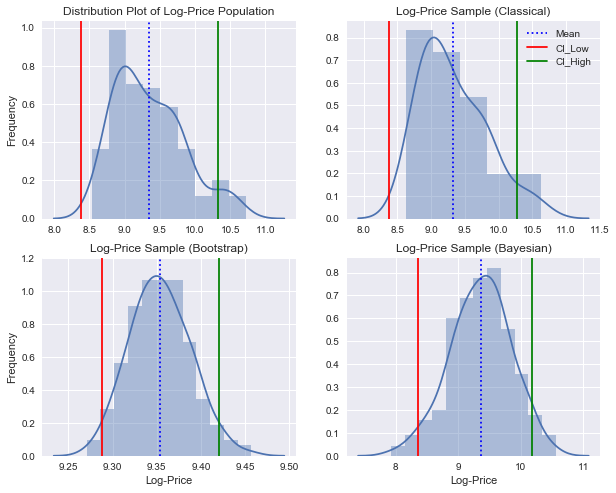

,Bayesian,Bootstrap,Classical,Population
Low-CI,8.351157,9.287509,8.376805,8.379776
High-CI,10.179114,9.420380,10.278430,10.325855


In [16]:
ClassicBootBayesConfInt(df['log-price'], 'Log-Price') # Log-Price CI DataFrame + Distribution plots

Compared with the Population CI, the Bayesian distribution credibility interval is more constrained. However, this is even moreso the case with the confidence intervals of the Bootstrap distribution, which differ from the Population CI by nearly 1 unit (log-price).  

#### 3.C CI for Log-Length

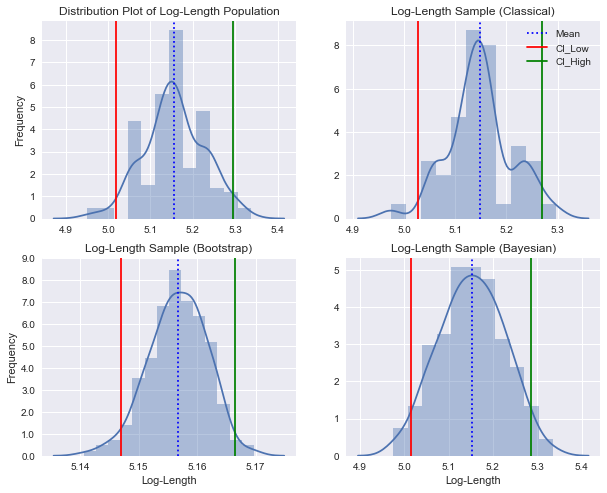

,Bayesian,Bootstrap,Classical,Population
Low-CI,5.014517,5.147007,5.026413,5.018175
High-CI,5.285328,5.166417,5.269885,5.295502


In [17]:
ClassicBootBayesConfInt(df['log-length'], 'Log-Length')

#### 3.D CI for Height

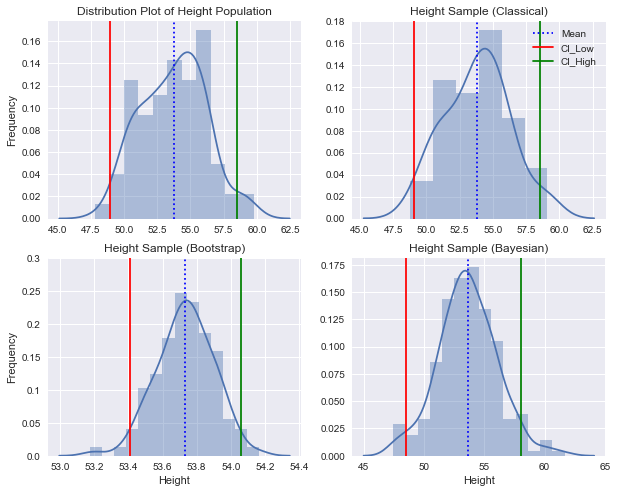

,Bayesian,Bootstrap,Classical,Population
Low-CI,48.466674,53.407197,49.096674,48.947358
High-CI,58.074790,54.059149,58.542541,58.502398


In [18]:
ClassicBootBayesConfInt(df['height'], 'Height')

#### 3.E CI for Log-Highway-mpg

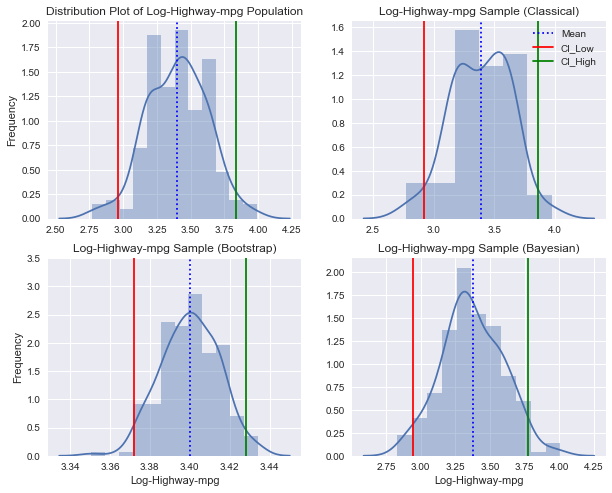

,Bayesian,Bootstrap,Classical,Population
Low-CI,2.946517,3.371857,2.918076,2.962544
High-CI,3.773512,3.428390,3.858720,3.839699


In [19]:
ClassicBootBayesConfInt(df['log-highway-mpg'], 'Log-Highway-mpg')

### Task 4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant

#### 4.A Defining Functions
#### Sampling

In [20]:
def stratify_series_maxsamp(df, series0name, group):
    
    """ Returns stratified sample of 'df'  series 'series0name' grouped by series 'group'. """
    
    groups = df.groupby(group)
    nums = min(groups.size())
    print(f'Group size for {series0name} grouped by {group}: {nums}')
    
    sample = groups.apply(lambda x: x.sample(n=nums)) # sampling from all groups based on min size
    strat_series = pd.Series(sample[series0name].reset_index(level=1, drop=True)) # dropping original
    
    return strat_series

#### Classical

In [21]:
def ANOVA_TukeyHSD_Classic(strat_series, series0name, groupbyname):
    
    """ Returns ANOVA and TukeyHSD statistics and plot for strat_series grouped by groupbyname. """
    
    # ANOVA
    num_samps = len(strat_series) # total samples
    groups = list(strat_series.index.unique()) # total groups
    groupvals = [np.asarray(strat_series[groups[i]]) for i in range(len(groups))] # group data arrays
    f_stat, p_value = ss.f_oneway(*groupvals) # f_test and p_vale for group data arrays
    print(f'\n===F-Test Statistics for {num_samps} {series0name} samples grouped by {groupbyname}===')
    print(f'...F-test  = {f_stat:{0}.{6}}.................................')
    print(f'...P-value = {p_value:{0}.{6}}.................................\n')
    
    # Tukey-HSD
    Tukey_HSD = pairwise_tukeyhsd(strat_series.values, strat_series.index) # obtaining Tukey_HSD report
    
    # Boxplot
    plt.boxplot([*groupvals]) # plotting all group data arrays
    plt.ylabel(f'{series0name}')
    plt.xlabel(f'{groupbyname}')
    plt.xticks(range(1, len(groups)+1), groups)
    plt.title(f'Boxplot of {groupbyname} distributions ({num_samps} samples total)')
    plt.show()
    
    return print(Tukey_HSD)

#### Bootstrap

In [22]:
def DiffMeansBootstrap(strat_series, series0name, grouping, group1name,
                       group2name, n_replicas, pval=0.05):
    
    """ Returns difference in means plots for bootstrapped group1 and group2 strat_series data """
    
    # obtaining group means and difference in means
    group1 = strat_series[strat_series.index == group1name]
    group2 = strat_series[strat_series.index == group2name]
    
    diffs = []
    group1_sample_means = []
    group2_sample_means = []
    for i in range(n_replicas):
        group1_sample_mean = group1.sample(frac=1.0, replace=True).mean()
        group2_sample_mean = group2.sample(frac=1.0, replace=True).mean()
        group1_sample_means.append(group1_sample_mean)
        group2_sample_means.append(group2_sample_mean)
        diffs.append(group1_sample_mean - group2_sample_mean)    
    
    # plotting group means (1) and difference of means (1)    
    plt.figure(figsize=(21,6))
    plt.suptitle('Bootstrap Difference of Means')
    
    ax1 = plt.subplot(121)
    
    sns.distplot(group1_sample_means, ax=ax1, color='r')
    plt.axvline(np.mean(group1_sample_means), color='r', ls=':', label=f'Mean: {group1name}')
    plt.axvline(np.percentile(group1_sample_means, pval * 100. / 2.), color='r', label=f'Low-CI: {group1name}')
    plt.axvline(np.percentile(group1_sample_means, 100 - pval * 100. / 2.), color='r', label=f'High-CI: {group1name}')
    
    sns.distplot(group2_sample_means, ax=ax1, color='b')
    plt.axvline(np.mean(group2_sample_means), color='b', ls=':', label=f'Mean: {group2name}')
    plt.axvline(np.percentile(group2_sample_means, pval * 100. / 2.), color='b', label=f'Low-CI: {group2name}')
    plt.axvline(np.percentile(group2_sample_means, 100 - pval * 100. / 2.), color='b', label=f'High-CI: {group2name}')
    
    plt.title(f"Bootstrap Distribution of Means  of {series0name} for\n" 
              f"{group1name} & {group2name} {grouping}")
    plt.xlabel(f"{series0name}")
    plt.ylabel(f"Frequency")
    plt.legend()
    
    ax2 = plt.subplot(122)
    sns.distplot(diffs, ax=ax2)
    plt.axvline(np.mean(diffs), color='b', ls=':', label='Mean')
    plt.axvline(np.percentile(diffs, pval * 100. / 2.), color='r', label='Low-CI')
    plt.axvline(np.percentile(diffs, 100 - pval * 100. / 2.), color='g', label='High-CI')
    plt.title(f"Bootstrap Distribution of Difference in Means \n between {group1name}"
              f" & {group2name} {grouping} groups for {series0name}")
    plt.xlabel(f"{series0name}")
    plt.ylabel(f"Frequency")
    plt.legend()
    plt.show()

    return 

#### Bayesian

In [23]:
def DiffMeansBayes(strat_series, series0name, grouping, group1name,
                       group2name, n_replicas, pval=0.05):

    """ Returns difference in means plots for bayesian 
    distributions of group1 and group2 strat_series data """
    
    # obtaining group samples
    group1 = strat_series[strat_series.index == group1name]
    group2 = strat_series[strat_series.index == group2name]
    
    groups = [group1, group2]
    
    # obtaining group posterior distributions
    post_samples = []
    for i in groups:
        # Creating prior
        p = np.linspace(min(i), max(i), num=n_replicas)
        pp = ss.norm.pdf(p, loc=i.mean(), scale=np.std(i))
        pp = pp / pp.sum()
        
        # Creating likelihood
        variance = np.std(i)**2
        x_mean = i.mean()
        n = len(i)
        l = np.exp(-n * (x_mean - p)**2 / (2 * variance))
        like_series = l / l.sum()
        
        # Creating posterior
        post_series = pp * like_series
        post_series = post_series / sum(post_series)
    
        # Sampling from distribution
        samples = np.random.choice(p, size=n_replicas, replace=True, p=post_series)
        samples = pd.Series(ss.norm.rvs(loc=samples, scale=np.std(i), size=n_replicas)) 
        post_samples.append(samples)
        
    # plotting group means (1) and difference of means (1)
    plt.figure(figsize=(21,6))
    plt.suptitle('Bayesian Difference of Means')
    
    ax1 = plt.subplot(121)
    
    sns.distplot(post_samples[0], ax=ax1, color='red')
    plt.axvline(np.mean(post_samples[0]), color='r', ls=':', label=f'Mean: {group1name}')
    plt.axvline(np.percentile(post_samples[0], pval * 100. / 2.), color='r', label=f'Low-CI: {group1name}')
    plt.axvline(np.percentile(post_samples[0], 100 - pval * 100. / 2.), color='r', label=f'High-CI: {group1name}')

    sns.distplot(post_samples[1], ax=ax1, color='blue')
    plt.axvline(np.mean(post_samples[1]), color='b', ls=':', label=f'Mean: {group2name}')
    plt.axvline(np.percentile(post_samples[1], pval * 100. / 2.), color='b', label=f'Low-CI: {group2name}')
    plt.axvline(np.percentile(post_samples[1], 100 - pval * 100. / 2.), color='b', label=f'High-CI: {group2name}')
    
    plt.title(f"Bayesian Posterior Distributions of {series0name} for\n" 
              f"{group1name} & {group2name} {grouping}")
    plt.xlabel(f"{series0name}")
    plt.ylabel(f"Frequency")
    plt.legend()
    
    ax2 = plt.subplot(122)
    sns.distplot(post_samples[0]-post_samples[1], ax=ax2)
    plt.axvline(np.mean(post_samples[0]-post_samples[1]), color='b', ls=':', label='Mean')
    plt.axvline(np.percentile(post_samples[0]-post_samples[1], pval * 100. / 2.), color='r', label='Low-CI')
    plt.axvline(np.percentile(post_samples[0]-post_samples[1], 100 - pval * 100. / 2.), color='g', label='High-CI')
    plt.title(f"Bayesian Posterior Distribution \n between {group1name}"
              f" & {group2name} {grouping} groups for {series0name}")
    plt.xlabel(f"{series0name}")
    plt.ylabel(f"Frequency")
    plt.legend()
    plt.show()

    return


#### 4.B Log-Price pair and population findings

##### Comparing Make groups based on Log-Price (Classical, TukeyHSD)

Group size for log-price grouped by make: 11

===F-Test Statistics for 99 log-price samples grouped by make===
...F-test  = 11.7208.................................
...P-value = 2.73952e-11.................................



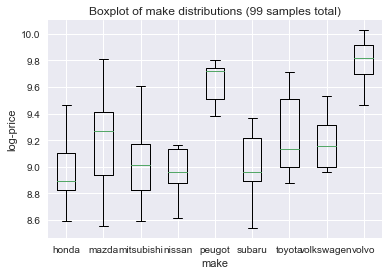

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1     group2   meandiff  lower   upper  reject
-----------------------------------------------------
  honda      mazda     0.2375  -0.1358  0.6108 False 
  honda    mitsubishi  0.0611  -0.3122  0.4345 False 
  honda      nissan    0.0942  -0.2791  0.4675 False 
  honda      peugot    0.6645   0.2912  1.0378  True 
  honda      subaru    0.0584  -0.3149  0.4317 False 
  honda      toyota    0.2786  -0.0947  0.6519 False 
  honda    volkswagen  0.2096  -0.1637  0.583  False 
  honda      volvo     0.8124   0.4391  1.1858  True 
  mazda    mitsubishi -0.1764  -0.5497  0.1969 False 
  mazda      nissan   -0.1433  -0.5166   0.23  False 
  mazda      peugot    0.427    0.0537  0.8003  True 
  mazda      subaru   -0.1791  -0.5524  0.1942 False 
  mazda      toyota    0.0411  -0.3322  0.4144 False 
  mazda    volkswagen -0.0279  -0.4012  0.3455 False 
  mazda      volvo     0.5749   0.2016  0.9483  True 
mitsubishi   nissan    0.033

In [24]:
dfmake = list(df['make'].value_counts().index[:9]) # greater than 10 entries
dfmake = df[df['make'].isin(dfmake)]

logprice_make_sample = stratify_series_maxsamp(dfmake, 'log-price', 'make')
ANOVA_TukeyHSD_Classic(logprice_make_sample, 'log-price', 'make')

The F-Stat and accompaning p-value clearly denote differences in log-price between car makes. The visual boxplot and tukey's hsd table show that these difference are between specific car makes, such as honda v. volvo, mitsubishi v. peugot, and volvo v. subaru.

##### Comparing the log-price distributions of Honda and Volvo makes (Bootstrap, Bayesian)

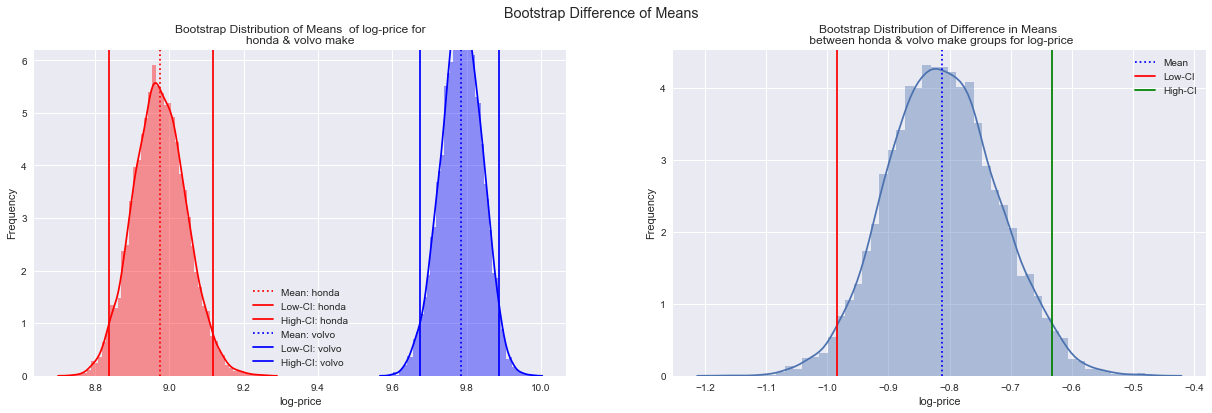

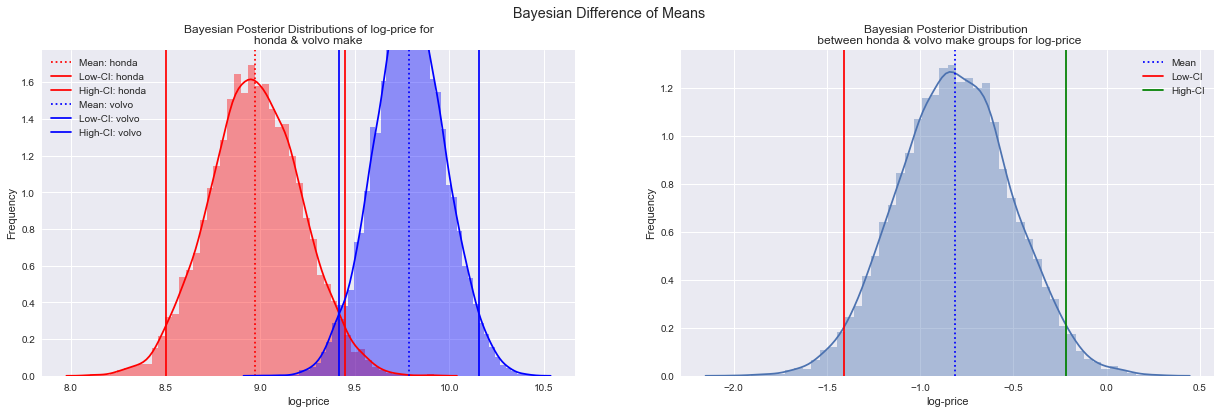

In [25]:
DiffMeansBootstrap(logprice_make_sample, 'log-price', 'make',
                   'honda', 'volvo', 10000, pval=0.05)
DiffMeansBayes(logprice_make_sample, 'log-price', 'make',
                   'honda', 'volvo', 10000, pval=0.05)

As described earlier, the Bootstrap distributions, having been created from sampling the series mean with replacement, has lower variance than the population it was sampled from and therefore a lower standard deviation. On the other hand, the Bayesian models slightly overlap on another, as the distributions have greater variance and a higher standard deviation. 

Based on both distributions, it is largely clear that honda and volvo car makes differ signfiicantly in terms of their log-price; however, the Bayesian model leaves room for doubt.

##### Comparing Num-of-cylinders groups based on Log-Price (Classical, TukeyHSD)

Group size for log-price grouped by num-of-cylinders: 11

===F-Test Statistics for 33 log-price samples grouped by num-of-cylinders===
...F-test  = 19.074.................................
...P-value = 4.5187e-06.................................



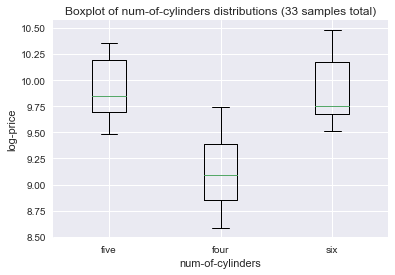

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 five   four  -0.7906   -1.154 -0.4272  True 
 five   six    -0.004  -0.3674  0.3594 False 
 four   six    0.7866   0.4232   1.15   True 
---------------------------------------------


In [26]:
dfcylnum = list(df['num-of-cylinders'].value_counts().index[:3]) # greater than 10 entries
dfcylnum = df[df['num-of-cylinders'].isin(dfcylnum)]

logprice_cylnum_sample = stratify_series_maxsamp(dfcylnum, 'log-price', 'num-of-cylinders')
ANOVA_TukeyHSD_Classic(logprice_cylnum_sample, 'log-price', 'num-of-cylinders')

##### Comparing the log-price distributions of four and six num-of-cylinders (Bootstrap, Bayesian)

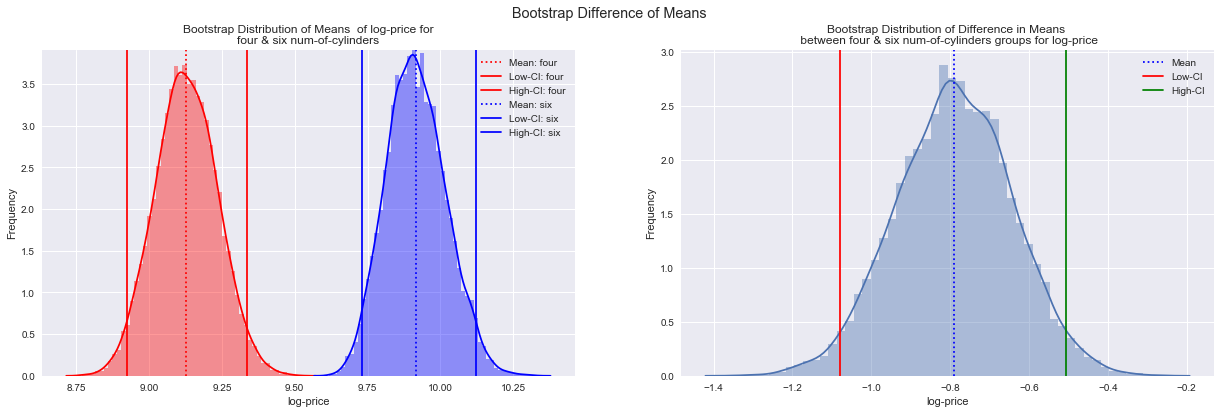

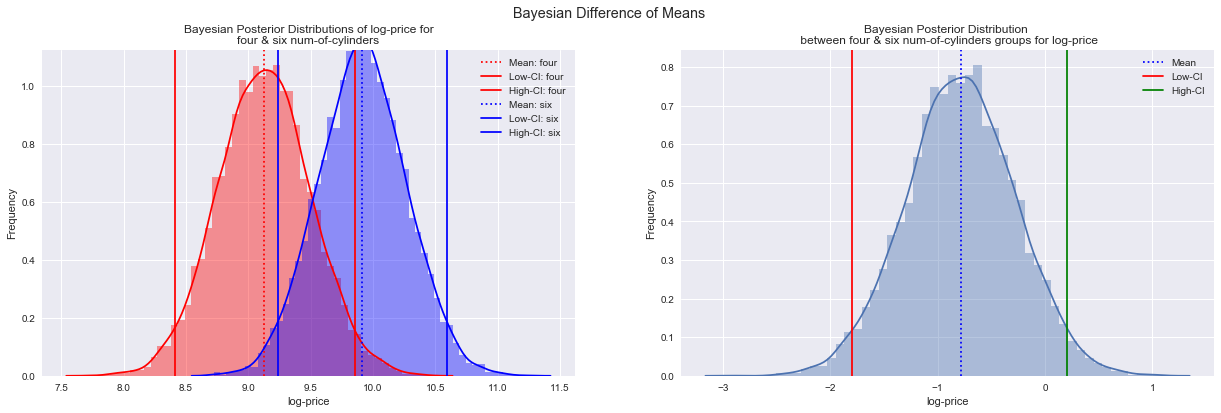

In [27]:
DiffMeansBootstrap(logprice_cylnum_sample, 'log-price', 'num-of-cylinders',
                   'four', 'six', 10000, pval=0.05)
DiffMeansBayes(logprice_cylnum_sample, 'log-price', 'num-of-cylinders',
                   'four', 'six', 10000, pval=0.05)

#### 4.C Log-Length pair and population findings

##### Comparing Fuel System groups based on Log-Length (Classical, TukeyHSD)

Group size for log-length grouped by fuel-system: 11

===F-Test Statistics for 44 log-length samples grouped by fuel-system===
...F-test  = 14.0082.................................
...P-value = 2.17582e-06.................................



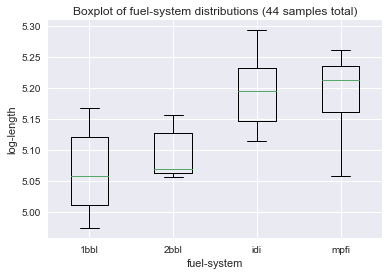

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 1bbl   2bbl   0.0311  -0.0377 0.0999 False 
 1bbl   idi    0.133    0.0642 0.2018  True 
 1bbl   mpfi   0.1292   0.0604 0.198   True 
 2bbl   idi    0.1019   0.0331 0.1707  True 
 2bbl   mpfi   0.0981   0.0293 0.1669  True 
 idi    mpfi  -0.0038  -0.0726 0.065  False 
--------------------------------------------


In [28]:
dffuelsys = list(df['fuel-system'].value_counts().index[:4]) # greater than 10 entries
dffuelsys = df[df['fuel-system'].isin(dffuelsys)]

loglength_fuelsys_sample = stratify_series_maxsamp(dffuelsys, 'log-length', 'fuel-system')
ANOVA_TukeyHSD_Classic(loglength_fuelsys_sample, 'log-length', 'fuel-system')

##### Comparing the log-length distributions of 1bbl and mpfi fuel-systems (Bootstrap, Bayesian)

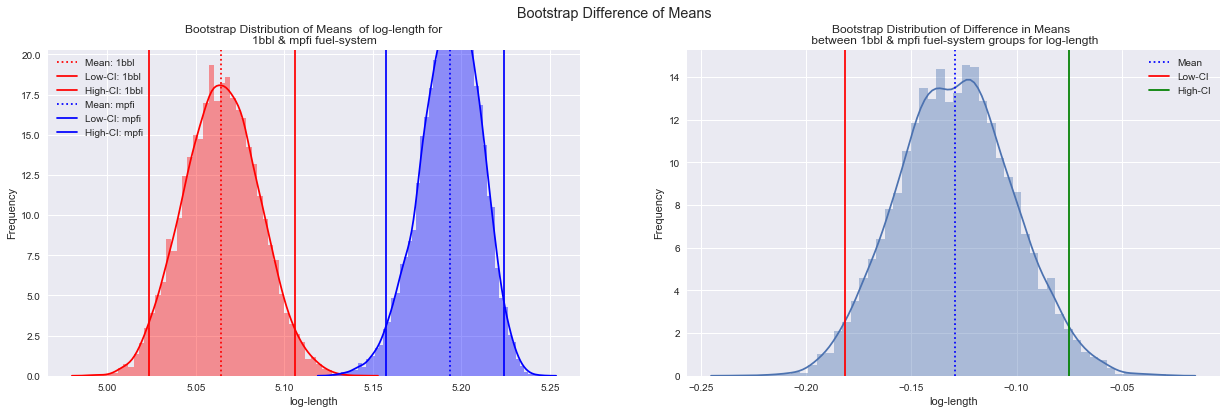

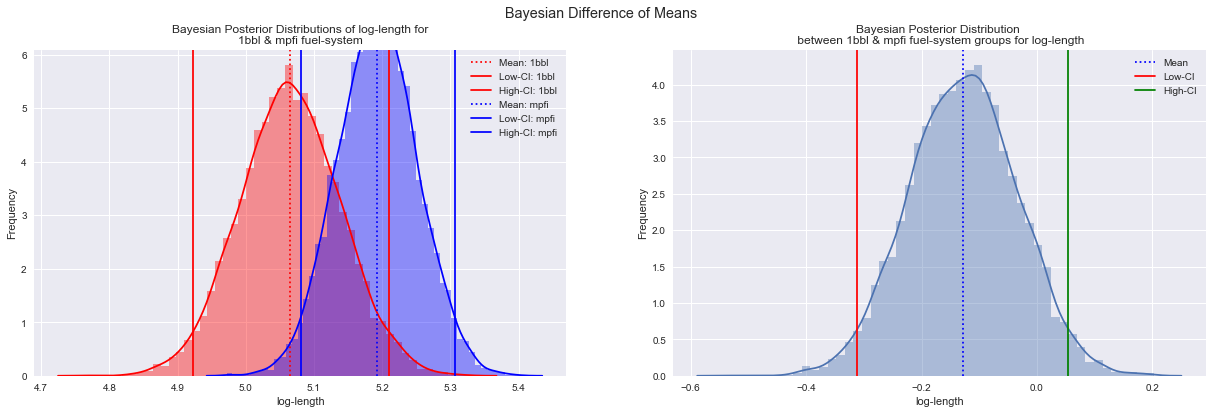

In [29]:
DiffMeansBootstrap(loglength_fuelsys_sample, 'log-length', 'fuel-system',
                   '1bbl', 'mpfi', 10000, pval=0.05)
DiffMeansBayes(loglength_fuelsys_sample, 'log-length', 'fuel-system',
                   '1bbl', 'mpfi', 10000, pval=0.05)

##### Comparing Symboling groups based on Log-Length (Classical, TukeyHSD)

Group size for log-length grouped by symboling: 22

===F-Test Statistics for 110 log-length samples grouped by symboling===
...F-test  = 16.5793.................................
...P-value = 1.468e-10.................................



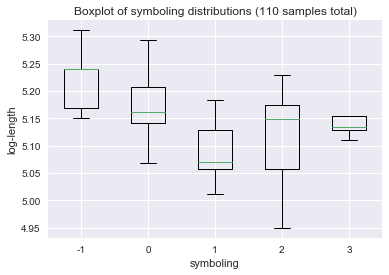

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  -1     0     -0.048  -0.0961   0.0   False 
  -1     1    -0.1288  -0.1768 -0.0807  True 
  -1     2    -0.1031  -0.1511  -0.055  True 
  -1     3    -0.0675  -0.1156 -0.0195  True 
  0      1    -0.0807  -0.1288 -0.0327  True 
  0      2     -0.055  -0.1031  -0.007  True 
  0      3    -0.0195  -0.0675  0.0286 False 
  1      2     0.0257  -0.0224  0.0737 False 
  1      3     0.0612   0.0132  0.1093  True 
  2      3     0.0356  -0.0125  0.0836 False 
---------------------------------------------


In [30]:
dfsymbol = list(df['symboling'].value_counts().index[:5]) # greater than 10 entries
dfsymbol = df[df['symboling'].isin(dfsymbol)]

loglength_symbol_sample = stratify_series_maxsamp(dfsymbol, 'log-length', 'symboling')
ANOVA_TukeyHSD_Classic(loglength_symbol_sample, 'log-length', 'symboling')

##### Comparing the log-length distributions of -1 and 3  symbolings (Bootstrap, Bayesian)

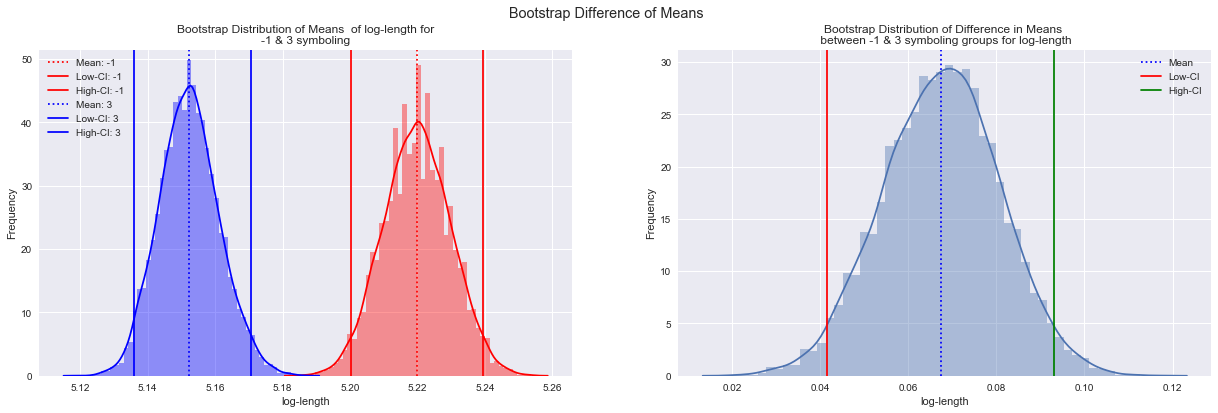

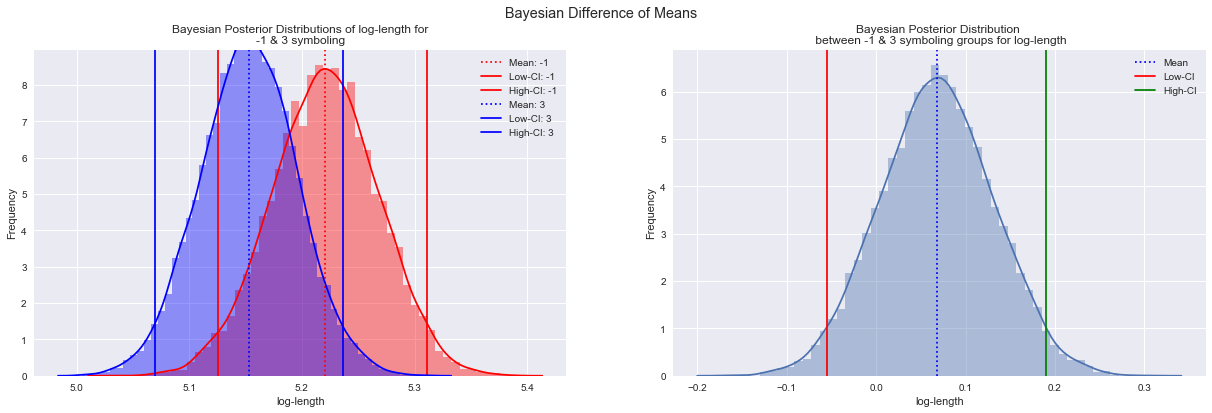

In [31]:
DiffMeansBootstrap(loglength_symbol_sample, 'log-length', 'symboling',
                   -1, 3, 10000, pval=0.05)
DiffMeansBayes(loglength_symbol_sample, 'log-length', 'symboling',
                   -1, 3, 10000, pval=0.05)

#### 4.D Height pair and population findings

##### Comparing Fuel-System groups based on Height (Classical, TukeyHSD)

Group size for height grouped by fuel-system: 11

===F-Test Statistics for 44 height samples grouped by fuel-system===
...F-test  = 2.88363.................................
...P-value = 0.0475465.................................



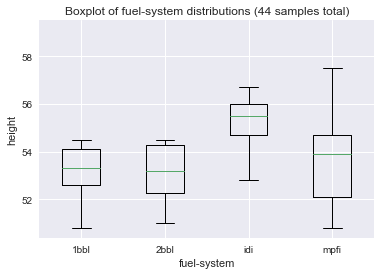

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 1bbl   2bbl    0.2    -2.0388 2.4388 False 
 1bbl   idi    2.1545  -0.0842 4.3933 False 
 1bbl   mpfi   0.2909  -1.9479 2.5297 False 
 2bbl   idi    1.9545  -0.2842 4.1933 False 
 2bbl   mpfi   0.0909  -2.1479 2.3297 False 
 idi    mpfi  -1.8636  -4.1024 0.3751 False 
--------------------------------------------


In [32]:
height_fuelsys_sample = stratify_series_maxsamp(dffuelsys, 'height', 'fuel-system')
ANOVA_TukeyHSD_Classic(height_fuelsys_sample, 'height', 'fuel-system')

##### Comparing the height distributions of 1bbl and idi fuel-systems (Bootstrap, Bayesian)

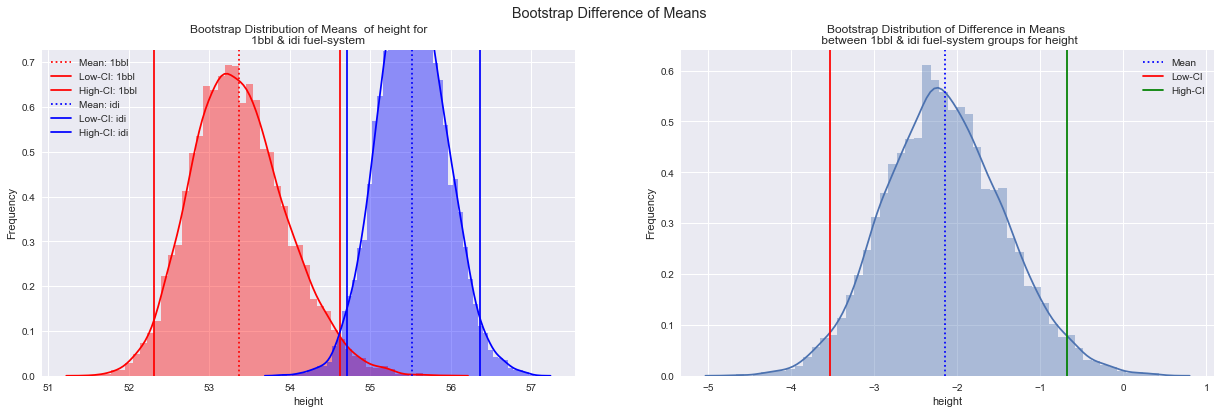

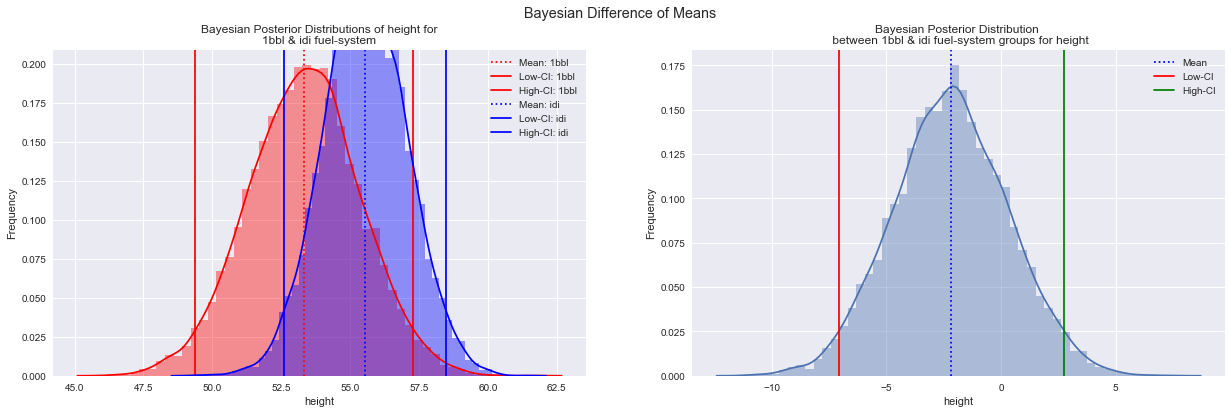

In [33]:
DiffMeansBootstrap(height_fuelsys_sample, 'height', 'fuel-system',
                   '1bbl', 'idi', 10000, pval=0.05)
DiffMeansBayes(height_fuelsys_sample, 'height', 'fuel-system',
                   '1bbl', 'idi', 10000, pval=0.05)

##### Comparing Make groups based on Height (Classical, TukeyHSD)

Group size for height grouped by make: 11

===F-Test Statistics for 99 height samples grouped by make===
...F-test  = 21.5289.................................
...P-value = 6.38573e-18.................................



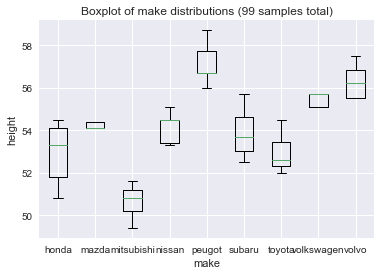

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1     group2   meandiff  lower   upper  reject
-----------------------------------------------------
  honda      mazda     0.2364  -1.6208  2.0935 False 
  honda    mitsubishi   -2.7   -4.5572 -0.8428  True 
  honda      nissan    0.3818  -1.4753  2.239  False 
  honda      peugot    3.8273   1.9701  5.6844  True 
  honda      subaru    0.5091  -1.3481  2.3662 False 
  honda      toyota   -0.4364  -2.2935  1.4208 False 
  honda    volkswagen  1.7818  -0.0753  3.639  False 
  honda      volvo     2.8818   1.0247  4.739   True 
  mazda    mitsubishi -2.9364  -4.7935 -1.0792  True 
  mazda      nissan    0.1455  -1.7117  2.0026 False 
  mazda      peugot    3.5909   1.7338  5.4481  True 
  mazda      subaru    0.2727  -1.5844  2.1299 False 
  mazda      toyota   -0.6727  -2.5299  1.1844 False 
  mazda    volkswagen  1.5455  -0.3117  3.4026 False 
  mazda      volvo     2.6455   0.7883  4.5026  True 
mitsubishi   nissan    3.081

In [34]:
height_make_sample = stratify_series_maxsamp(dfmake, 'height', 'make')
ANOVA_TukeyHSD_Classic(height_make_sample, 'height', 'make')

##### Comparing the height distributions of mitsubishi and toyota makes (Bootstrap, Bayesian)

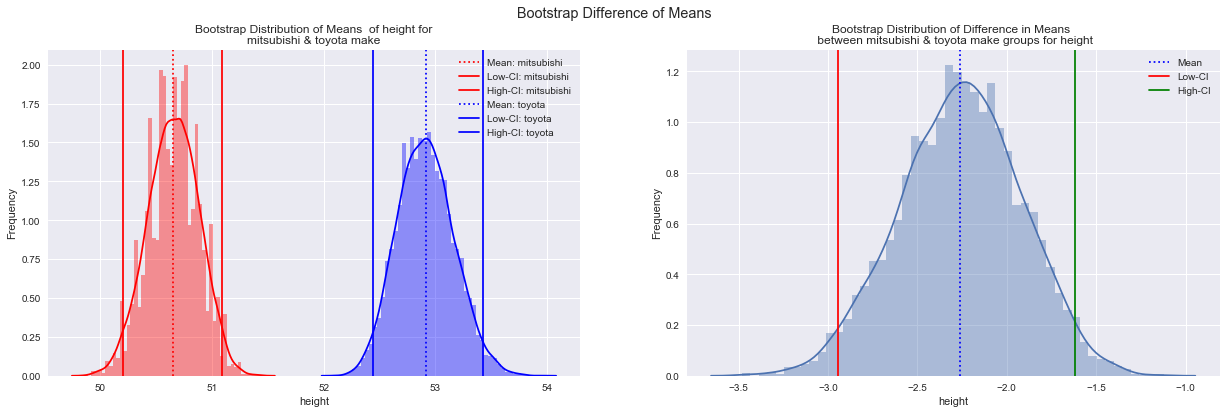

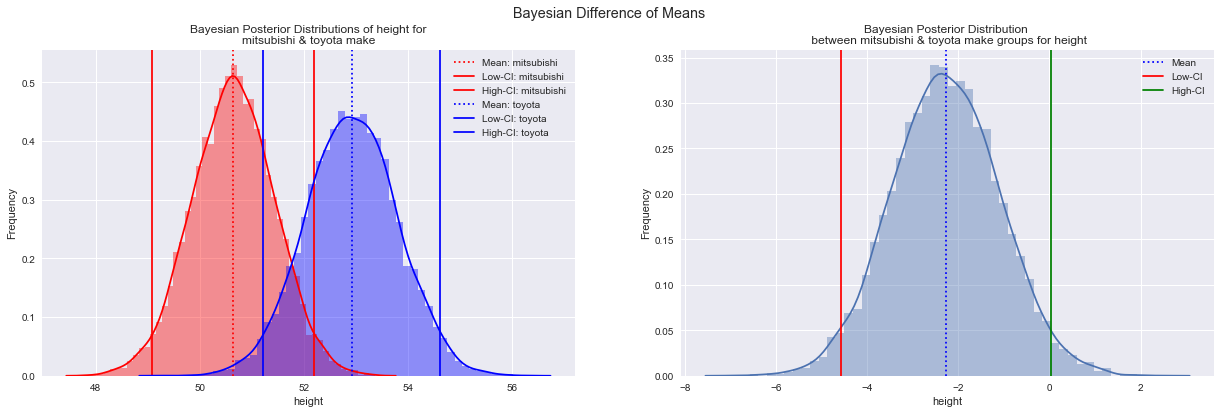

In [35]:
DiffMeansBootstrap(height_make_sample, 'height', 'make',
                   'mitsubishi', 'toyota', 10000, pval=0.05)
DiffMeansBayes(height_make_sample, 'height', 'make',
                   'mitsubishi', 'toyota', 10000, pval=0.05)

#### 4.E Log-Highway-mpg pair and population findings

##### Comparing Num-of-cylinders groups based on Log-Highway-mpg (Classical, TukeyHSD)

Group size for log-highway-mpg grouped by num-of-cylinders: 11

===F-Test Statistics for 33 log-highway-mpg samples grouped by num-of-cylinders===
...F-test  = 38.48.................................
...P-value = 5.22996e-09.................................



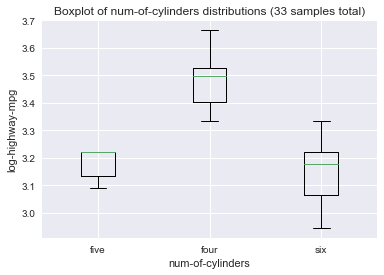

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 five   four   0.3072   0.2021  0.4123  True 
 five   six   -0.0314  -0.1365  0.0738 False 
 four   six   -0.3385  -0.4437 -0.2334  True 
---------------------------------------------


In [36]:
loghighwaympg_cylnum_sample = stratify_series_maxsamp(dfcylnum, 'log-highway-mpg', 'num-of-cylinders')
ANOVA_TukeyHSD_Classic(loghighwaympg_cylnum_sample, 'log-highway-mpg', 'num-of-cylinders')

##### Comparing the Log-Highway-mpg distributions of five and four num-of-cylinders (Bootstrap, Bayesian)

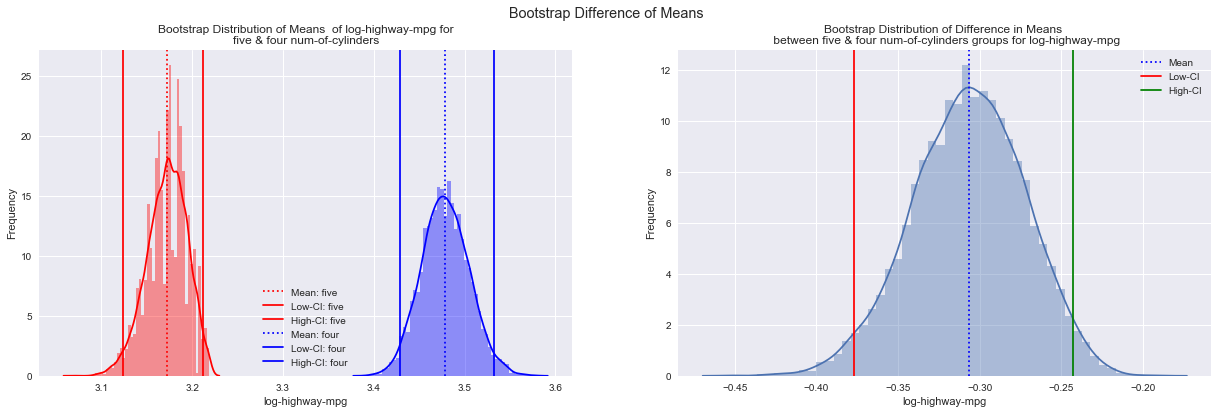

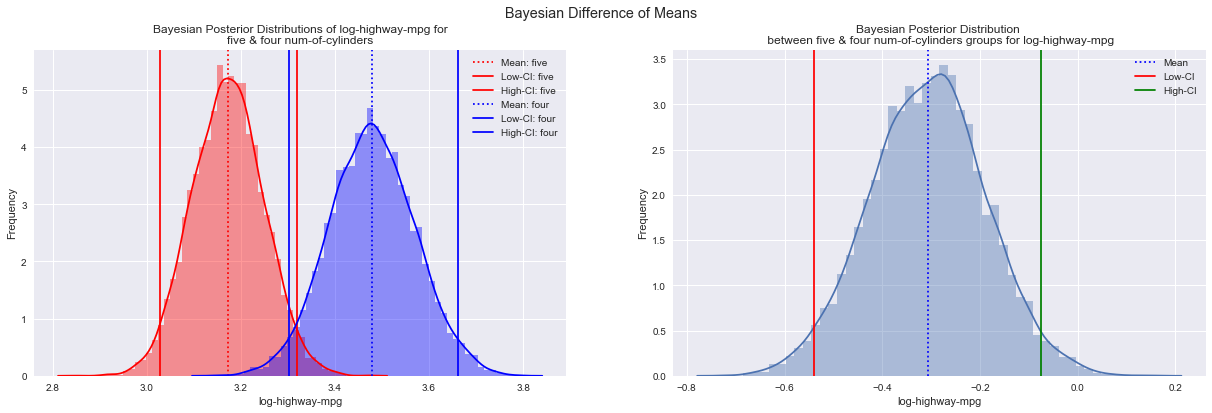

In [37]:
DiffMeansBootstrap(loghighwaympg_cylnum_sample, 'log-highway-mpg', 'num-of-cylinders',
                   'five', 'four', 10000, pval=0.05)
DiffMeansBayes(loghighwaympg_cylnum_sample, 'log-highway-mpg', 'num-of-cylinders',
                   'five', 'four', 10000, pval=0.05)

##### Comparing Symboling groups based on Log-Highway-mpg (Classical, TukeyHSD)

Group size for log-highway-mpg grouped by symboling: 22

===F-Test Statistics for 110 log-highway-mpg samples grouped by symboling===
...F-test  = 12.6311.................................
...P-value = 1.99355e-08.................................



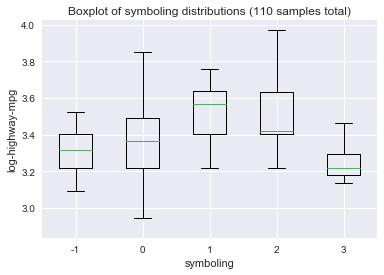

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  -1     0     0.0574  -0.0863  0.2011 False 
  -1     1     0.2285   0.0848  0.3722  True 
  -1     2     0.2124   0.0687  0.3561  True 
  -1     3    -0.0663   -0.21   0.0774 False 
  0      1     0.1711   0.0274  0.3148  True 
  0      2     0.155    0.0113  0.2987  True 
  0      3    -0.1238  -0.2675  0.0199 False 
  1      2    -0.0161  -0.1598  0.1276 False 
  1      3    -0.2948  -0.4385 -0.1511  True 
  2      3    -0.2787  -0.4224  -0.135  True 
---------------------------------------------


In [38]:
loghighwaympg_symbol_sample = stratify_series_maxsamp(dfsymbol, 'log-highway-mpg', 'symboling')
ANOVA_TukeyHSD_Classic(loghighwaympg_symbol_sample, 'log-highway-mpg', 'symboling')

##### Comparing the Log-Highway-mpg distributions of 1 and 3 symbolings (Bootstrap, Bayesian)

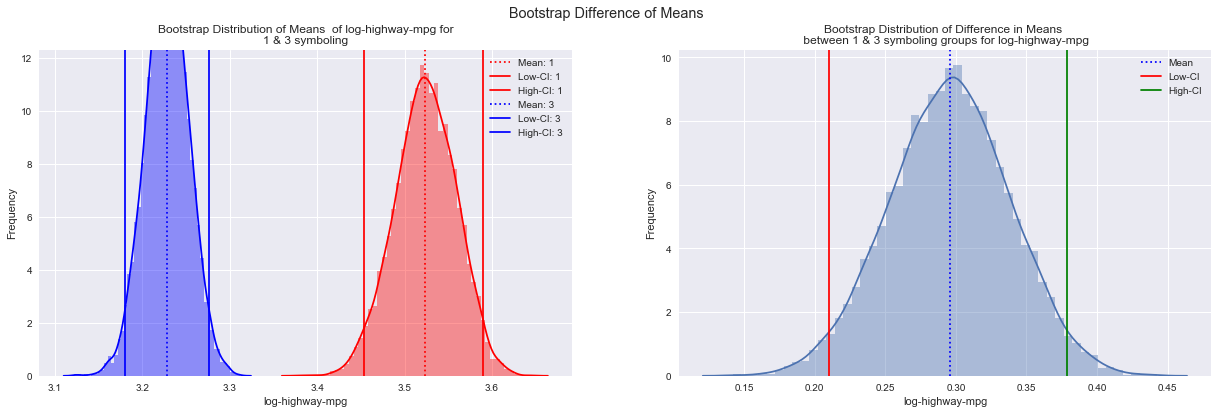

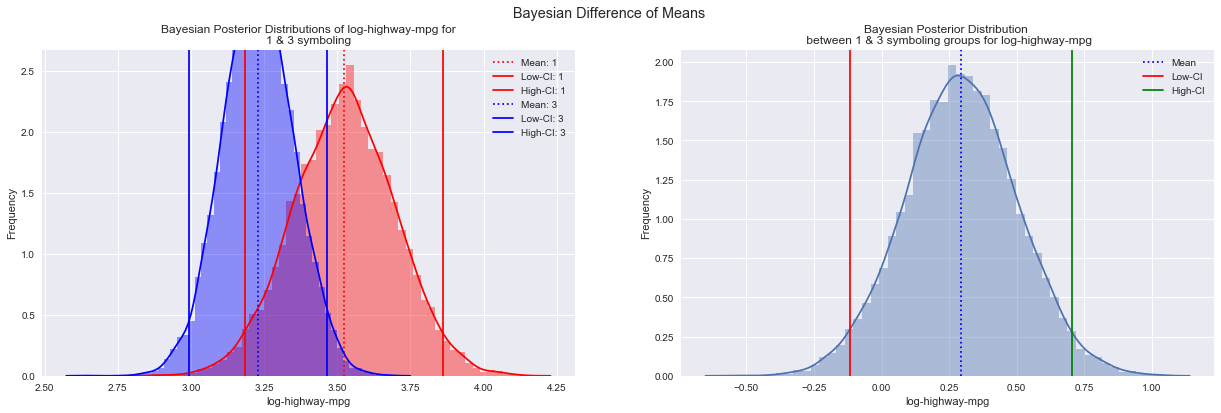

In [39]:
DiffMeansBootstrap(loghighwaympg_symbol_sample, 'log-highway-mpg', 'symboling',
                   1, 3, 10000, pval=0.05)
DiffMeansBayes(loghighwaympg_symbol_sample, 'log-highway-mpg', 'symboling',
                   1, 3, 10000, pval=0.05)